
# LoRaSim-AIM: simulate collisions in LoRa using the additive interference model
Extension to the original LoRaSim by Thiemo Voigt <thiemo@sics.se> and Martin Bor <m.bor@lancaster.ac.uk>

This work is licensed under the Creative Commons Attribution 4.0
International License. To view a copy of this license,
visit http://creativecommons.org/licenses/by/4.0/.

In [2]:
# imports
import simpy
import random
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
import os

import lorasim_engine

In [3]:
# parameters

# max number of nodes to cycle through for different plots
maxNrNodes = 2000
# max number of base-stations
maxNrBS = 1

# other parameters that are constant
avgSendTime = 1200000
simtime = 24*3600*1000 # time in ms
packetLength = 11 # size of payload in bytes

# IIM model collision setting: Full collision considers the capture effect
full_collision = True

# define the maximum simulation area
maxX = 10000 # in m
maxY = 10000 # in m

# log-distance model parameters
Ptx = 16 # in dBm
gamma = 2.08 # NOTE: replace with actual values from regression
d0 = 380 # place-holder value - Adwait (original LoraSim: 40.0)
var = 0 # NOTE: variance ignored for now. 3.57 in Lorasim paper
Lpld0 = 109 # place-holder value - Adwait (original LoraSim: 127.41)
GL = 0

# this is an array with measured values for sensitivity
# see LoRa scaling paper, Table 1
sf7 = np.array([7,-126.5,-124.25,-120.75])
sf8 = np.array([8,-127.25,-126.75,-124.0])
sf9 = np.array([9,-131.25,-128.25,-127.5])
sf10 = np.array([10,-132.75,-130.25,-128.75])
sf11 = np.array([11,-134.5,-132.75,-128.75])
sf12 = np.array([12,-133.25,-132.25,-132.25])

# array of sensitivity values
sensi = np.array([sf7,sf8,sf9,sf10,sf11,sf12])

In [4]:
# plotting
def plotSensitivity(sensi):
    sensi_fig = plt.figure()

    s125, = plt.plot(sensi[:,0], sensi[:,1],"bo-", label="125 kHz")
    s250, = plt.plot(sensi[:,0], sensi[:,2],"ko:", label="250 kHz")
    s500, = plt.plot(sensi[:,0], sensi[:,3],"ro--", label="500 kHz")

    plt.legend(title="Bandwidth", handles = [s125, s250, s500])
    plt.grid()
    plt.xlabel("Spreading Factor (2^)")
    plt.ylabel("Base-station Receiver\nSensitivity (dBm)")
    plt.xticks([6,7,8,9,10,11,12])

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    plt.show()
    
# plotSensitivity(sensi)

def plotAirtime():
    
    cr = 1 # fixed coding rate
    pl = 20 # fixed payload length in bytes
    
    bw_list = [125, 250, 500]
    sf_list = [6, 7, 8, 9, 10, 11, 12]
    
    time_in_air = np.zeros((len(bw_list), len(sf_list)))
    
    for i,bw in enumerate(bw_list):
        for j,sf in enumerate(sf_list):
            time_in_air[i,j] = airtime(sf, cr, pl, bw)
            
    airtime_fig = plt.figure()
    
    at125, = plt.plot(sf_list, time_in_air[0,:], "bo-", label="125 kHz")
    at250, = plt.plot(sf_list, time_in_air[1,:], "ko:", label="250 kHz")
    at500, = plt.plot(sf_list, time_in_air[2,:], "ro--", label="500 kHz")

    plt.legend(title="Bandwidth", handles = [at125, at250, at500])
    plt.grid()
    plt.xlabel("Spreading Factor")
    plt.ylabel("Packet Airtime (ms)")
    plt.xticks([6,7,8,9,10,11,12])

    plt.rcParams["font.family"] = "sans-serif"
    plt.rcParams["font.size"] = 20
    
    plt.show()
    
# plotAirtime()

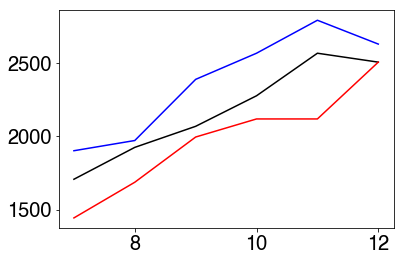

In [10]:
# node placement

Lpl_matrix = Ptx - (sensi[:,1:])
maxDist = np.dot(d0, np.exp(np.divide((Lpl_matrix - Lpld0),(10*gamma))))

bestDist = np.amax(maxDist)

def plotMaxDistFig():
    maxDist_fig = plt.figure()
    plt.plot(sensi[:,0], maxDist[:,0], 'b', label="125 kHz")
    plt.plot(sensi[:,0], maxDist[:,1], 'k', label="250 kHz")
    plt.plot(sensi[:,0], maxDist[:,2], 'r', label="500 kHz")
    plt.show()
    
# plotMaxDistFig()

===== Location generation =====
generated locations for 1 base-stations
generated locations for 2000 nodes


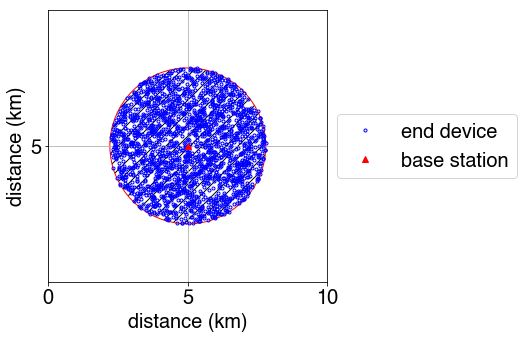

In [7]:
BSLoc = np.zeros((maxNrBS, 3))
nodeLoc = np.zeros((maxNrNodes, 3))

def placeRandomly(number, locArray, xRange, yRange):
    for n in xrange(number):
        x = random.uniform(xRange[0], xRange[1])
        y = random.uniform(yRange[0], yRange[1])
        locArray[n,:] = [n, x, y]
        
def placeRandomlyInRange(number, locArray, xRange, yRange, refLoc):
    for n in xrange(number):
#         rounds = 0
        while True:
            # This could technically turn into an infinite loop but that shouldn't ever practically happen.
            # add check here later
            x = random.uniform(xRange[0], xRange[1])
            y = random.uniform(yRange[0], yRange[1])
            if np.any(np.sum(np.square(refLoc[:,1:3] - np.array([x,y]).reshape(1,2)), axis=1) <= bestDist**2):
                locArray[n,:] = [n, x, y]
                break
        
print "===== Location generation ====="

random.seed(1)

if maxNrBS == 1:
    BSLoc[0] = [0, maxX*0.5, maxY*0.5]
else:
    placeRandomly(maxNrBS, BSLoc, [maxX*0.1, maxX*0.9], [maxY*0.1, maxY*0.9])
print "generated locations for {} base-stations".format(maxNrBS)

placeRandomlyInRange(maxNrNodes, nodeLoc, [0, maxX], [0, maxY], BSLoc)
print "generated locations for {} nodes".format(maxNrNodes)

# np.save("bsList_bs{}_nodes{}.npy".format(maxNrBS, maxNrNodes), BSLoc)
# np.save("nodeList_bs{}_nodes{}.npy".format(maxNrBS, maxNrNodes), nodeLoc)

def plotLocations():
    loc_plot = plt.figure(figsize = (5,5))
    loc_ax = plt.gca()
    
    bestDist = np.amax(maxDist)
    
    bestDist = np.amax(maxDist)
    for b in BSLoc[:,1:3]:
        loc_ax.add_artist(plt.Circle((b[0], b[1]), bestDist, fill=False, hatch='//', color = 'red'))
    
    nodePoints, = plt.plot(nodeLoc[:,1], nodeLoc[:,2], "b.", mfc='none', label="end device")
    bsPoints, = plt.plot(BSLoc[:,1], BSLoc[:,2], "r^", label="base station")
    
    plt.xticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    plt.yticks([0, 5000, 10000, 15000, 20000], [0,5,10,15,20])
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid()
    
    plt.axis('equal')
    plt.xlim((0, maxX))
    plt.ylim((0, maxY))
    
    plt.xlabel('distance (km)')
    plt.ylabel('distance (km)')
    
    plt.show()
    
plotLocations()

## Packet Collisions

A number of things determine if 2 or more packets would collide in the air: overlapping spectrum of transmissions, spreading factor leakages, timing collisions etc.

The traditional method of modelling this is using the independent interference model, which checks for the interference between any two packets currently in the air (and not more). This is the method currently used by the original LoRaSim.

Another method is the more complex additive interference model. The next few section will test both of these

In [36]:
import lorasim_engine


# collision checks using the independent interference model
# the collision functions are heavily dependent on the object definitions

#
# main discrete event loop, runs for each node
# a global list of packet being processed at the gateway
# is maintained
#
def transmit(env,node):
    
    global packetSeq
    global nrBS
    global nrLost
    global nrTransmitted
    global nrReceived
    global nrCollisions
    
    while True:
        yield env.timeout(random.expovariate(1.0/float(node.period)))

        # time sending and receiving
        # packet arrives -> add to base station

        node.sent = node.sent + 1
        
        packetSeq = packetSeq + 1

        for bs in range(0, nrBS):
            if (node in packetsAtBS[bs]):
                print "ERROR: packet already in"
            else:
                # adding packet if no collision
                if (checkcollision(node.packet[bs])==1):
                    node.packet[bs].collided = 1
                else:
                    node.packet[bs].collided = 0
                packetsAtBS[bs].append(node)
                node.packet[bs].addTime = env.now
                node.packet[bs].seqNr = packetSeq

        # take first packet rectime
        yield env.timeout(node.packet[0].rectime)
        
        nrTransmitted += 1

        # if packet did not collide, add it in list of received packets
        # unless it is already in
        
        packetLostFlag = True
        collisionFlag = False
        for bs in range(0, nrBS):
            if node.packet[bs].lost:
                lostPackets.append(node.packet[bs].seqNr)
            else:
                if node.packet[bs].collided == 0:
                    packetLostFlag = False
                    packetsRecBS[bs].append(node.packet[bs].seqNr)
                    if (recPackets):
                        if (recPackets[-1] != node.packet[bs].seqNr):
                            recPackets.append(node.packet[bs].seqNr)
                    else:
                        recPackets.append(node.packet[bs].seqNr)
                else:
                    # XXX only for debugging
                    collidedPackets.append(node.packet[bs].seqNr)
                    collisionFlag = True
                    
        if packetLostFlag:
            nrLost += 1
        else:
            nrReceived += 1
            
        if collisionFlag:
            nrCollisions += 1
            
        # complete packet has been received by base station
        # can remove it
        for bs in range(0, nrBS):
            if (node in packetsAtBS[bs]):
                packetsAtBS[bs].remove(node)
                # reset the packet
                node.packet[bs].collided = 0
                node.packet[bs].processed = 0

In [37]:
simSetting = list(np.linspace(100,2000,20,endpoint = True, dtype=int))

totalTransmitted = []
totalLost = []
totalReceived = []
totalCollided = []

for i,n in enumerate(simSetting):
    # global stuff
    nrNodes = n
    nodes = []
    bs = []
    packetsAtBS = []
    packetsRecBS = []

    env = simpy.Environment()


    # max distance: 300m in city, 3000 m outside (5 km Utz experiment)
    # also more unit-disc like according to Utz
    nrLost = 0
    nrCollisions = 0
    nrReceived = 0
    nrTransmitted = 0

    # global value of packet sequence numbers
    packetSeq = 0

    # list of received packets
    recPackets=[]
    collidedPackets=[]
    lostPackets = []

    # some feedback on what's going on

    print "===== Setup parameters ====="
    print "grid size = {} m x {} m".format(maxX, maxY)
    print "# base-stations = {}".format(nrBS)
    print "# nodes = {}".format(nrNodes)
    print "minimum sensitivity (dBm) = {}".format(np.amin(sensi))
    np.set_printoptions(precision=2, suppress=True)
    print "calculated max transmission distance (m) =\n{}".format(maxDist)

    ## create all the base-stations

    for b_loc in BSLoc:
        b = myBS(int(b_loc[0]), (b_loc[1], b_loc[2]))
        bs.append(b)
        packetsAtBS.append([])
        packetsRecBS.append([])
    
    for node_loc in nodeLoc[0:nrNodes, :]:
        n = myNode(int(node_loc[0]), (node_loc[1], node_loc[2]), avgSendTime, 20) # send a packet of 20 bytes every 20 min
        nodes.append(n)
        env.process(transmit(env, n))

    print "===== simulation objects created ====="

    env.run(until=simtime)

    # print "nr received packets", len(recPackets)
    # print "nr collided packets", len(collidedPackets)
    # print "nr lost packets", len(lostPackets)

    print "# transmitted = {}".format(nrTransmitted)
    print "# received = {}".format(nrReceived)
    print "# lost = {}".format(nrLost)
    print "# collisions = {}".format(int(nrCollisions))
    
    totalTransmitted.append(nrTransmitted)
    totalReceived.append(nrReceived)
    totalLost.append(nrLost)
    totalCollided.append(nrCollisions)
    
print "nodes: {}".format(simSetting)
print "Transmitted: {}".format(totalTransmitted)
print "Received: {}".format(totalReceived)
print "Collisions: {}".format(totalCollided)

===== Setup parameters =====
grid size = 10000 m x 10000 m
# base-stations = 1
# nodes = 100
minimum sensitivity (dBm) = -134.5
calculated max transmission distance (m) =
[[ 1902.17  1707.14  1442.75]
 [ 1972.    1925.17  1686.74]
 [ 2390.16  2069.13  1995.85]
 [ 2568.89  2277.96  2119.47]
 [ 2794.37  2568.89  2119.47]
 [ 2631.39  2507.87  2507.87]]
===== simulation objects created =====
# transmitted = 7172
# received = 6896
# lost = 276
# collisions = 276
===== Setup parameters =====
grid size = 10000 m x 10000 m
# base-stations = 1
# nodes = 200
minimum sensitivity (dBm) = -134.5
calculated max transmission distance (m) =
[[ 1902.17  1707.14  1442.75]
 [ 1972.    1925.17  1686.74]
 [ 2390.16  2069.13  1995.85]
 [ 2568.89  2277.96  2119.47]
 [ 2794.37  2568.89  2119.47]
 [ 2631.39  2507.87  2507.87]]
===== simulation objects created =====
# transmitted = 14278
# received = 13166
# lost = 1112
# collisions = 1112
===== Setup parameters =====
grid size = 10000 m x 10000 m
# base-statio

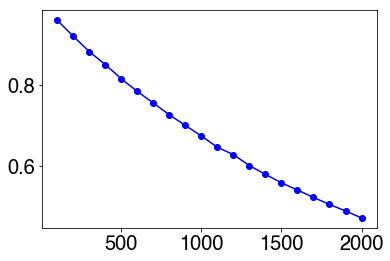

In [38]:

def plotIIMPacketReception():
    
#     print totalReceived
#     print totalTransmitted
    
#     print np.divide(np.array(totalReceived, dtype=float), np.array(totalTransmitted, dtype=float))

    iimDerPlot = plt.figure()
    plt.plot(simSetting, np.divide(np.array(totalReceived, dtype=float), np.array(totalTransmitted, dtype=float)), 'bo-')
    plt.show()
    
plotIIMPacketReception()

# Additive interference model

In [10]:
## The Additive Interference Model

# required constants
nSF = 7

def getFreqBucketsFromSet(BSFreqSetList):
    ## This function gives a list of frequencies for various bandwidths used by our basestations
    ## This is only applicable to the US 902-928 specifications.
    ## Other regions would need their own functions
    
    ## TODO: update this function for white-space frequencies
    
    
    freqSetList = np.unique(BSFreqSetList)
#     freq125 = np.array([], dtype=int)
#     freq500 = np.array([],dtype=int)
    freq125 = set()
    freq500 = set()
    for i in freqSetList:
        freq125.update(np.linspace(902300 + 200*8*i, 903700 + 200*8*i, 8, dtype=int))
        freq500.add(903000 + 1600*i)

    return freq125,freq500

class myBS_AIM():
    def __init__(self, bsid, position, BSFreqSetList = []):
        self.bsid = bsid
        self.x, self.y = position
        
        if BSFreqSetList:
            # non empty list provided
            self.freqSetList = BSFreqSetList
        else:
            # get a random default frequency
            self.freqSetList = random.randint(0,7)
            
        # RX frequencies are stored as a set for easy searching later
        self.RXFreq125, self.RXFreq500 = getFreqBucketsFromSet(self.freqSetList)
        
        self.noiseFloor = noiseFloor_AIM(self.RXFreq125)
        
    def updateRXFreqSet(self, BSFreqSetList):
        self.RXFreq125, self.RXFreq500 = getFreqBucketsFromSet(BSFreqSetList)
        
    
class myNode_AIM():
    def __init__(self, nodeid, position):
        self.nodeid = nodeid
        self.x, self.y = position
        self.sent = 0
    
class myPacket_AIM():
    def __init__(self, nodeid, bsid, packetno, pTX, fc, bw, sf, cr, plen):
        self.fc = fc
        self.bw = bw
        self.sf = sf
        self.cr = cr
        self.pTX = pTX
        self.toCheck = False # This flag is only turned on in the critical section of the preamble
    
class noiseFloor_AIM():
    def __init__(self, freqBuckets):
        
        noiseBucket = {}
        for freq in freqBuckets:
            noiseBucket = np.zeros(nSF)
    
    def addPacket(self, packet):
        # Add a packet to the noise floor
        pass
    
    def removePacket(self, packet):
        # Remove a packet from the noise floor
        pass
    
    def evaluate(self, target = None):
        # Evaluate all active packets
        pass
    
## various types of transmit functions define each individual experiment

def transmitStatic():
    # this assumed the radio assignemnts for a node are static, and do not change later
    # We select a given static assignment in the whole network
    pass

def transmitSpecADR():
    # this assumed the radio assignemnts for a node are static, and do not change later
    # We select the best static assignment for the given location
    pass

def transmitFixedSF():
    # this method only uses power control
    pass